# Projet 5 - Catégorisez automatiquement des questions

## Importation des librairies et des données et conversions

In [1]:
import numpy as np
import pandas as pd
import gensim
import scipy
from sklearn.decomposition import LatentDirichletAllocation
import csv
from sklearn import preprocessing
from sklearn import decomposition
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn import svm
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate
import time
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, plot_confusion_matrix

In [2]:
test_mx = pd.read_csv('test_mx.csv', sep=';', index_col=0)
train_mx = pd.read_csv('train_mx.csv', sep=';', index_col=0)
fw_dict = pd.read_csv('fw_dict.csv')
test_df = pd.read_csv('processed_test_df.csv', sep=';',
                      index_col=0, converters={'processed_tags': eval})
train_df = pd.read_csv('processed_train_df.csv', sep=';',
                       index_col=0, converters={'processed_tags': eval})

In [3]:
feature_name = []
with open('feature_name.csv', 'r') as data:
    for line in csv.reader(data):
        feature_name.append(line)

# Transforme la liste de listes en liste
feature_names = [item for sublist in feature_name for item in sublist]

In [4]:
fw_dict = fw_dict.to_dict(orient='list')

In [5]:
train_mx

,ab,abc,able,absolute,abstract,accept,access,accomplish,according,account,...,xsd,xxx,year,yes,yet,yield,z,zero,zip,zygoteinit
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.207299,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69553,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69554,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69555,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69556,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
train_feature = scipy.sparse.csr_matrix(train_mx.values)

In [7]:
train_feature

<69558x1624 sparse matrix of type '<class 'numpy.float64'>'
	with 2390868 stored elements in Compressed Sparse Row format>

In [8]:
len(feature_names)

1624

In [9]:
feature_names

['ab',
 'abc',
 'able',
 'absolute',
 'abstract',
 'accept',
 'access',
 'accomplish',
 'according',
 'account',
 'achieve',
 'across',
 'action',
 'actionbar',
 'active',
 'activerecord',
 'activity',
 'activitythread',
 'actual',
 'actually',
 'ad',
 'adapter',
 'adb',
 'add',
 'added',
 'adding',
 'additional',
 'address',
 'admin',
 'advance',
 'advantage',
 'advice',
 'age',
 'agent',
 'ajax',
 'alert',
 'algorithm',
 'alias',
 'align',
 'alloc',
 'allow',
 'allowed',
 'allows',
 'almost',
 'along',
 'alpha',
 'already',
 'also',
 'alternative',
 'although',
 'always',
 'amount',
 'android',
 'androidruntime',
 'angular',
 'angularjs',
 'animated',
 'animation',
 'annotation',
 'anonymous',
 'another',
 'answer',
 'anybody',
 'anyone',
 'anything',
 'anyway',
 'anywhere',
 'apache',
 'api',
 'apk',
 'app',
 'apparently',
 'appcompat',
 'appear',
 'appears',
 'append',
 'apple',
 'application',
 'apply',
 'appreciate',
 'appreciated',
 'approach',
 'appropriate',
 'apps',
 'archite

## LDA

In [10]:
lda = LatentDirichletAllocation(n_components=11, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)

lda.fit(train_feature)

LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          max_iter=5, n_components=11, random_state=0)

In [11]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [12]:
n_top_words = 40
print("\nTopics in LDA model: ")
print_top_words(lda, feature_names, n_top_words)


Topics in LDA model: 
Topic #0:
div html jquery element image page text javascript cs function class browser width button li script using event tag content like height click document window id j want link span href chrome way work style var scroll get display code
Topic #1:
input form character text field value regex name string submit type label email checkbox validation textbox password match replace button javascript letter binding id validate jquery attribute radio remove check user val number html regular pattern checked required expression address
Topic #2:
difference map php hash memory lock v marker explain google maximum heap term md mb sha limit hi use friend someone performance two size please echo usage q speed mean one operator fast advantage understand used example reduce anyone confused
Topic #3:
self view swift cell nsstring objective io nil controller uiview frame delegate uitableview tableview alloc init nslog iphone animated navigation func yes layer bar button xcod

## ACP

On extrait le 1er tag de chaque ligne pour créer 'y' de la base train et test. Il faut encoder les données sur le dataframe contenant toutes les données pour éviter des problèmes liés avec des tags qui apparaissent dans une base et non l'autre

### LabelEncoder

In [41]:
full_df = pd.concat([train_df, test_df])
pre_base = [full_df['processed_tags'].iloc[i][0]
            for i in range(len(full_df['processed_tags']))]
le = preprocessing.LabelEncoder()
le.fit(pre_base)

LabelEncoder()

In [14]:
pre_ytrain = [train_df['processed_tags'].iloc[i][0]
              for i in range(len(train_df['processed_tags']))]
y_train = le.transform(pre_ytrain)

In [15]:
pre_ytest = [test_df['processed_tags'].iloc[i][0]
             for i in range(len(test_df['processed_tags']))]
y_test = le.transform(pre_ytest)

### OneHotEncoder

In [47]:
type(pre_base)

list

In [58]:
ohe = preprocessing.OneHotEncoder()
ohe.fit(np.array(pre_base).reshape(-1,1))

OneHotEncoder()

In [59]:
y_train_ohe = ohe.transform(np.array(pre_ytrain).reshape(-1,1))
y_test_ohe = ohe.transform(np.array(pre_ytest).reshape(-1,1))

In [60]:
print(pre_ytrain)

['java', 'python', 'css', 'java', 'python', 'javascript', 'java', 'android', 'ios', '.net', 'c', 'android', 'ios', 'ios', 'c++', 'javascript', 'python', 'c#', 'ios', 'java', 'c#', 'python', 'ios', 'java', 'mysql', 'java', 'c#', 'php', 'php', 'objective-c', 'c', 'javascript', 'objective-c', 'php', 'c#', 'javascript', 'python', 'html', 'html', 'c#', 'javascript', 'javascript', 'java', 'git', 'c#', 'python', 'python', 'jquery', 'c#', 'android', 'c++', 'c', 'android', 'java', 'java', 'android', 'javascript', 'git', 'python', 'java', 'c++', 'html', 'c++', 'html', 'c', 'java', 'python', 'c#', 'sql', 'python', 'python', 'python', 'ruby-on-rails', 'node.js', 'javascript', 'java', 'javascript', 'python', 'c#', 'php', 'c++', 'ios', 'python', 'javascript', 'python', 'android', 'iphone', 'ios', 'c#', 'php', 'ruby-on-rails', 'html', 'java', 'javascript', 'javascript', 'git', 'java', 'javascript', 'git', 'java', 'python', 'python', 'c#', 'xcode', 'c#', 'iphone', 'c++', 'python', 'git', 'python', 'cs

In [16]:
y_test.shape

(17392,)

In [17]:
# Normalisation de la base train
std_scale = preprocessing.StandardScaler().fit(train_mx)
X_scaled = std_scale.transform(train_mx)

In [18]:
# Normalisation de la base test selon la base test
X_scaled_test = std_scale.transform(test_mx)

On test l'ACP avec plusieurs nombres de composants

In [19]:
# On calcul les 2 premieres composantes principales
pca = decomposition.PCA(n_components=800)
pca.fit(X_scaled)

# projeter X sur les composantes principales
train_projected = pca.transform(X_scaled)

In [20]:
test_projected = pca.transform(X_scaled_test)

In [21]:
# Pourcentage de la variance expliquee
# print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.sum())

0.6018736381904386


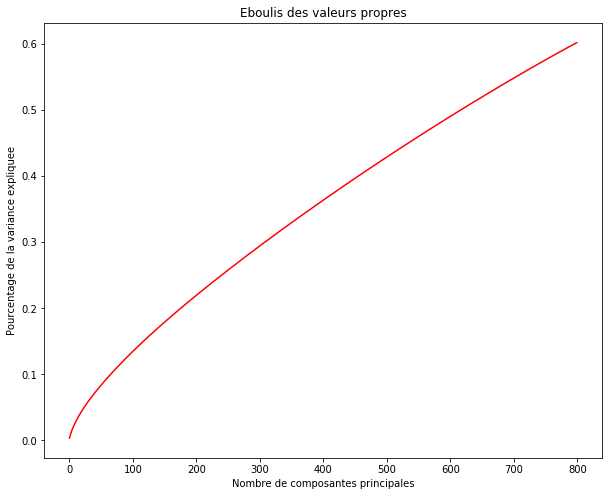

In [22]:
plt.figure(figsize=(10, 8))
scree = pca.explained_variance_ratio_*100
#plt.bar(np.arange(len(scree))+1, scree)
plt.plot(np.arange(len(scree)), np.cumsum(pca.explained_variance_ratio_), 'r-')
plt.xlabel('Nombre de composantes principales')
plt.ylabel('Pourcentage de la variance expliquee')
plt.title("Eboulis des valeurs propres")
plt.show(block=False)

On enregistre les composantes dans une variable qui devient le nouveau x_train

In [25]:
train_projected.shape

(69558, 800)

## V1 - Modélisation

### Arbre de décision

In [ ]:
X_scaled.shape

In [ ]:
y_train.shape

In [ ]:
tree_reg = DecisionTreeRegressor()
scores = cross_validate(estimator=tree_reg, X=train_projected, y=y_train, cv=5, scoring=(
    'r2', 'neg_mean_squared_error'), return_train_score=True)

scores

In [ ]:
print('R² moyen pour data train:', scores['train_r2'].mean())
print('Erreur quadratique moyenne pour data train:',
      scores['train_neg_mean_squared_error'].mean())

print('R² moyen pour data test:', scores['test_r2'].mean())
print('Erreur quadratique moyenne pour data test:',
      scores['test_neg_mean_squared_error'].mean())

In [ ]:
debut = time.time()
decision_tree = DecisionTreeRegressor()
decision_tree.fit(train_projected, y_train)
fin = time.time()
print('R² avec modèle: Arbre de décision:',
      decision_tree.score(test_projected, y_test))

### Modèle logistique

In [ ]:
type(y_train)

In [ ]:
model = LogisticRegression()
parameters = {'penalty': ['none'], 'C': [
    0.01, 1, 100], 'max_iter': [1000]}
gs_reglog = GridSearchCV(model, parameters, scoring=(
    'r2', 'neg_mean_squared_error', 'neg_root_mean_squared_error'), refit='r2', cv=5)
gs_reglog.fit(train_projected, y_train)

In [ ]:
modele_logit = LogisticRegression(penalty='none')
modele_logit.fit(train_projected, y_train)

### SVM

In [ ]:
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(X_scaled, y_train)

## V2 - Modélisation sur un échantillon

Pour tester le bon fonctionnement des modèles, nous avons sélectionné les 10 000 première valeurs de X et Y afin de pouvoir faire tourner les algorithmes plus facilement. Cependant le résultat de ces tests là ne sont pas pris en compte dans le choix du modèle final.

In [23]:
X_scaled.shape

(69558, 1624)

In [24]:
y_train.shape

(69558,)

In [13]:
X = train_projected[:10000]
y = y_train[:10000]

### Arbre de décision

In [15]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(X, y)
#y_pred = tree_reg.predict(X_scaled_test)

#print(f1_score(y_test, y_pred, average='micro'))
#print(precision_score(y_test, y_pred, average="macro"))
#print(recall_score(y_test, y_pred, average="macro"))
#print(classification_report(y_test, y_pred))

DecisionTreeRegressor()

In [16]:
y_pred = tree_reg.predict(test_projected[:10000])

print(f1_score(y_test[:10000], y_pred, average='micro'))
print(precision_score(y_test[:10000], y_pred, average="macro"))
print(recall_score(y_test[:10000], y_pred, average="macro"))
print(classification_report(y_test[:10000], y_pred))

0.3152
0.05523394051158053
0.054750286899203894
              precision    recall  f1-score   support

         0.0       0.02      0.02      0.02       148
         3.0       0.00      0.00      0.00         2
         5.0       0.46      0.49      0.48       936
         8.0       0.00      0.00      0.00         1
         9.0       0.00      0.00      0.00         1
        10.0       0.00      0.00      0.00         0
        11.0       0.00      0.00      0.00         0
        12.0       0.00      0.00      0.00         1
        13.0       0.00      0.00      0.00        16
        14.0       0.00      0.00      0.00         1
        17.0       0.00      0.00      0.00         1
        19.0       0.00      0.00      0.00         1
        24.0       0.15      0.15      0.15       218
        25.0       0.28      0.27      0.27      1168
        27.0       0.40      0.43      0.42       667
        29.0       0.00      0.00      0.00         1
        32.0       0.00      0.00

C:\Users\Happy\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Happy\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Happy\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Happy\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: Undef

### Régression logistique

In [47]:
log_reg = LogisticRegression()
log_reg.fit(X, y)

C:\Users\Happy\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

In [48]:
y_pred = log_reg.predict(test_projected[:10000])

print(f1_score(y_test[:10000], y_pred, average='micro'))
print(precision_score(y_test[:10000], y_pred, average="macro"))
print(recall_score(y_test[:10000], y_pred, average="macro"))
print(classification_report(y_test[:10000], y_pred))

0.6051
0.15131366315651257
0.14486056082680068
              precision    recall  f1-score   support

           0       0.11      0.14      0.12       148
           3       0.00      0.00      0.00         2
           5       0.65      0.64      0.65       936
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         1
          12       0.00      0.00      0.00         1
          13       0.30      0.19      0.23        16
          14       0.00      0.00      0.00         1
          17       0.00      0.00      0.00         1
          19       0.00      0.00      0.00         1
          24       0.48      0.44      0.46       218
          25       0.58      0.55      0.57      1168
          27       0.65      0.67      0.66       667
          29       0.00      0.00      0.00         1
          39       0.00      0.00      0.00         1
          41       0.34      0.30      0.32       187
          43       0.00      0.00 

C:\Users\Happy\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Happy\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Happy\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Happy\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: Undef

### SVM

In [49]:
svm = SVC()
svm.fit(X, y)

KeyboardInterrupt: 

In [ ]:
y_pred = svm.predict(test_projected[:10000])

print(f1_score(y_test[:10000], y_pred, average='micro'))
print(precision_score(y_test[:10000], y_pred, average="macro"))
print(recall_score(y_test[:10000], y_pred, average="macro"))
print(classification_report(y_test[:10000], y_pred))

## Modélisation finale

### Choix du modèle

In [26]:
X = train_projected
y = y_train

In [62]:
type(test_projected)

numpy.ndarray

In [31]:
print(X.shape)
print(y.shape)
print(test_projected.shape)
print(y_test.shape)

(69558, 800)
(69558,)
(17392, 800)
(69558,)


In [36]:
print('X:', X)
print('y:', y)
print('test_projected:', test_projected)
print('y_train:', y_train)

X: [[ 3.22247688e+00 -2.42461957e+00  6.54955673e+00 ... -4.82202340e-01
   1.04309578e+00 -1.88899232e-01]
 [-2.79324004e+00  1.32067703e+00  2.00330188e+00 ...  2.40768127e-01
   1.23670719e+00 -6.84654361e-01]
 [ 3.92499842e+00 -6.17697480e-01 -3.62641059e+00 ...  5.53234409e-01
   1.16028344e+00 -5.77054312e-01]
 ...
 [-2.16409282e+00  6.49857121e-01  7.61818321e-02 ... -9.18433073e-01
  -1.42358718e+00 -2.22053533e+00]
 [-4.05075327e-01  1.52069440e+00 -1.26786713e+00 ... -1.97972572e-01
  -5.75216070e-01  4.42512967e-01]
 [-2.07020786e-03  1.08097349e+00 -2.87555493e-01 ... -8.24723264e-01
  -8.33822744e-01 -1.39063875e+00]]
y: [ 97 141  41 ... 141  97 141]
test_projected: [[ 3.67405859 -1.54020905 -1.91161695 ...  0.82538411  0.51641196
  -2.27999286]
 [ 0.85689261 -0.49372096  0.70703809 ... -0.25723689 -0.08652425
  -1.35393228]
 [-0.0665297  -2.07932311 -0.52259018 ...  1.07787528  0.01248609
   2.15461288]
 ...
 [-2.61594037  2.2601689  -0.80960727 ... -0.70375878  0.7336368

In [30]:
# Sauvegarde des données pour utiliser dans google colab
np.savetxt('X.csv', X, delimiter=',', fmt='%d')
np.savetxt('Y.csv', y, delimiter=',', fmt='%d')
np.savetxt('test_proj.csv', test_projected, delimiter=',', fmt='%d')
np.savetxt('y_test.csv', y_test, delimiter=',', fmt='%d')

#### Arbre de décision

In [39]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(X, y)
y_pred = tree_reg.predict(test_projected)

In [39]:
#y_pred = tree_reg.predict(test_projected)

print(f1_score(y_test, y_pred, average='micro'))
print(precision_score(y_test, y_pred, average="macro"))
print(recall_score(y_test, y_pred, average="macro"))
print(classification_report(y_test, y_pred))

ValueError: Classification metrics can't handle a mix of multiclass and continuous targets

#### Régression logistique

In [72]:
log_reg = LogisticRegression()
log_reg.fit(X, y)

C:\Users\Happy\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

In [75]:
y_pred = log_reg.predict(test_projected)

print(f1_score(y_test, y_pred, average='micro'))
print(precision_score(y_test, y_pred, average="macro"))
print(recall_score(y_test, y_pred, average="macro"))
print(classification_report(y_test, y_pred))

0.7159038638454461
0.13747049606896664
0.1340205019867874
              precision    recall  f1-score   support

           0       0.29      0.14      0.19       242
           3       0.00      0.00      0.00         4
           5       0.81      0.81      0.81      1588
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         3
           9       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         1
          12       0.00      0.00      0.00         1
          13       0.13      0.07      0.10        27
          14       0.00      0.00      0.00         1
          17       0.00      0.00      0.00         1
          19       0.00      0.00      0.00         1
          22       0.00      0.00      0.00         1
          24       0.51      0.45      0.48       375
          25       0.68      0.73      0.71      2056
          27       0.76      0.75      0.75      1209
          29       0.00

C:\Users\Happy\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Happy\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Happy\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Happy\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: Undef

#### SVM

In [26]:
svm = SVC()
svm.fit(X, y)

SVC()

In [27]:
y_pred = svm.predict(test_projected)

print(f1_score(y_test, y_pred, average='micro'))
print(precision_score(y_test, y_pred, average="macro"))
print(recall_score(y_test, y_pred, average="macro"))
print(classification_report(y_test, y_pred))

0.7228035878564858
0.14843834396391611
0.13602927639506357
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       242
           3       0.00      0.00      0.00         4
           5       0.80      0.84      0.82      1588
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         3
           9       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         1
          12       0.00      0.00      0.00         1
          13       0.00      0.00      0.00        27
          14       0.00      0.00      0.00         1
          17       0.00      0.00      0.00         1
          19       0.00      0.00      0.00         1
          22       0.00      0.00      0.00         1
          24       0.62      0.35      0.45       375
          25       0.63      0.78      0.70      2056
          27       0.75      0.75      0.75      1209
          29       0.0

C:\Users\Happy\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Happy\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Tuning des paramètres

#### Grid Search

In [22]:
param_grid = {
    'penalty': ['l1', 'none'],
    'C': [1, 10, 100],
    'max_iter': [100, 500]
}

In [23]:
model = LogisticRegression()

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring="accuracy", verbose=2, n_jobs=-1)

In [26]:
best_model = grid_search.fit(X, y)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


C:\Users\Happy\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 16.0min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 132.8min finished
C:\Users\Happy\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [27]:
grid_search.best_params_

{'C': 1, 'max_iter': 100, 'penalty': 'none'}

In [28]:
grid_search.best_score_

0.7078984122716542

In [ ]:
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [1, 10],
    'max_iter': [100, 1000]
}
model = LogisticRegression()

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring="accuracy", verbose=2, n_jobs=-1)
best_model = grid_search.fit(X, y)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


C:\Users\Happy\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 13.5min
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 117.1min finished
